In [5]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
import equadratures as eq

# Data-driven dimension reduction in turbomachinery

In this tutorial, we will look at some of the material in this [ASME Turbo Expo paper](http://dx.doi.org/10.1115/GT2020-16277), which explores the design of a probe used to measure the stagnation temperature in gas-turbine engines. By using *equadratures* to reduce the dimensionality of the design space, the probes' performance parameters can be more effectively visualised, and physical insights obtained.

## Load the data

The data consists of Computational Fluid Dynamics (CFD) simulations of $N=128$ temperature probes. The probe geometries are parameterised by $d=7$ design parameters, with the design space sampled using Latin Hypercube sampling. 

The input design vectors are stored in $\mathbf{X}\in \mathbb{R}^{N\times d}$, and two design objectives $y_1,y_2 \in \mathbb{R}^{N \times 1}$ are considered. We wish to minimise both of these objectives, which represent the following (see Sections 2 and 6 in the paper for more details):

1. $y_1$: Stagnation pressure loss coefficient $Y_p$ averaged across the Mach number range. 

2. $y_2$: Gradient of recovery ratio w.r.t to Mach number $\partial R_r/\partial M$.

The data can be downloaded from the [equadratures dataset repo](https://github.com/equadratures/data-sets) using the `datasets.load_eq_dataset` method. As in the paper, $X$ is standardised to lie within the interval $[-1,1]$. Unlike in the paper, for commerical privacy reasons, $y_1$, $y_2$ are also standardised here. 

In [10]:
data = eq.datasets.load_eq_dataset('probes')
X  = data['X']
y1 = data['y1']
y2 = data['y2']
Xheader = ['Hole $\oslash$','Kiel $\oslash_{inner}$','Kiel $\oslash_{outer}$',\
           'Kiel lip fwd/back','Hole angle','Hole fwd/back','Hole ellipse'] 


 ## Summary
This dataset contains temperature recovery and loss data for a set of 128 probe designs, used in the 2020 ASME Turbo Expo [paper](https://asmedigitalcollection.asme.org/GT/proceedings-abstract/GT2020/84089/V02CT35A057/1094558):

"Design space exploration of stagnation temperature probes via dimension reduction" (GT2020-16277)

Each design is obtained by deforming a baseline design parameterised with seven design parameters. The baseline design is representative of a single-shrouded stagnation temperature probe used aero-engines. Data is obtained with the SU2 CFD solver, with the freestream Mach number varied from 0.3 to 0.8. All input and output data has been standardised to lie within the interval [-1,1].

## Description of Data
There are $N=128$ designs and $d=7$ design parameters. The input design vectors are stored in $\mathbf{X}\in \mathbb{R}^{N\times d}$, while the three design objectives are stored in $y_1,y_2,y_3 \in \mathbb{R}^{N \times 1}$.

The design objectives

## Find a 1D subspace for loss coefficient
Here we find a subspace for the loss coefficient design objective $y_1$ ($O_{Yp}$ in the paper). From a [previous grid search](https://github.com/ascillitoe/probe-subspaces/blob/main/Example_Notebooks/grid_search.ipynb), we know a 1D subspace ($m=1$) and $1^{st}$ order polynomial ($k=1$) are suitable.

The subspace procedure is not deterministic (there is an element of randomness involved). Sometimes poor subspaces are obtained. We can judge by looking at $R^2$ or simply plotting the summary plot (see later). In this event we simply rerun until we find a subspace we are happy with. This does mean that it is good practice to save a subspace  to file for future analysis, instead of generating a new one each time. 

You can save a subspace with `joblib.dump(mysubspace1,'Yp_subspace.joblib')` for example.

In [12]:
m1 = 1 # number of reduced dimensions
k1 = 1 # polynomial order

# Find subspace via variable projection
mysubspace1 = eq.Subspaces(method='variable-projection',sample_points=X,\
                        sample_outputs=y1,polynomial_degree=k1, subspace_dimension=m1)
    
# Get the subspace vector, and the polynomial approximation
W1 = mysubspace1.get_subspace() 
active_subspace1 = W1[:,0:m1]
u1 = X @ active_subspace1
subpoly1 = mysubspace1.get_subspace_polynomial()

It is good practice to check the accuracy of the subspace (we use adjusted $R^2$ here), and also visualise its predictions.

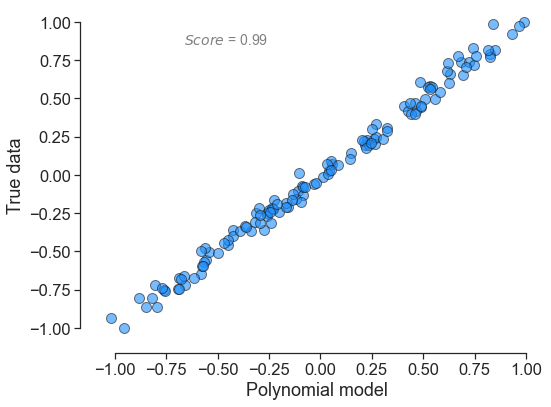

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Polynomial model', ylabel='True data'>)

In [16]:
subpoly1.plot_model_vs_data(metric='r2')

If we are happy with the quality of the obtained subspace, we can go ahead and generate a *sufficient summary plot*.

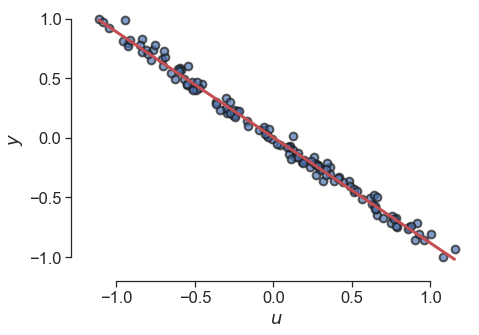

(<Figure size 504x360 with 1 Axes>, <AxesSubplot:xlabel='$u$', ylabel='$y$'>)

In [18]:
mysubspace1.plot_sufficient_summary()

## Find a 2D subspace for the recovery ratio gradient
Here we find a subspace for the recovery ratio gradient design objective $y_2$ ($O_{Rr}$ in the paper). From a previous grid search, we know a 2D subspace ($m=2$) and $3^{rd}$ order polynomial ($k=3$) are suitable.

**Note:** This one is trickier! You might need to rerun it a few times to get a good $R^2$ value.

In [20]:
m2 = 2 # number of reduced dimensions
k2 = 3 # polynomial order

# Find subspace via variable projection
mysubspace2 = eq.Subspaces(method='variable-projection',sample_points=X,\
                        sample_outputs=y2,polynomial_degree=k2, subspace_dimension=m2)
    
# Get the subspace vector, and the polynomial approximation
W2 = mysubspace2.get_subspace()
active_subspace2 = W2[:,0:m2]
u2 = X @ active_subspace2
subpoly2 = mysubspace2.get_subspace_polynomial()

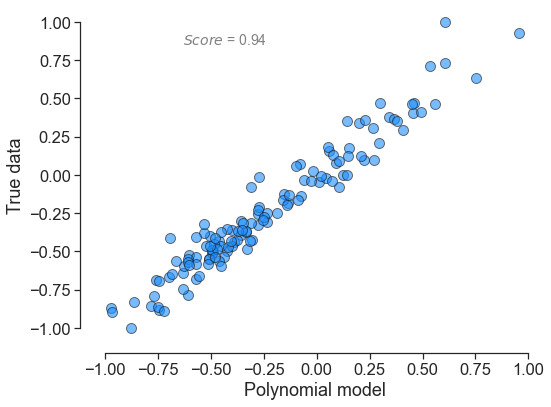

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Polynomial model', ylabel='True data'>)

In [21]:
subpoly2.plot_model_vs_data(metric='r2')

Now generate a *sufficient summary plot* again. This time a 2D one!

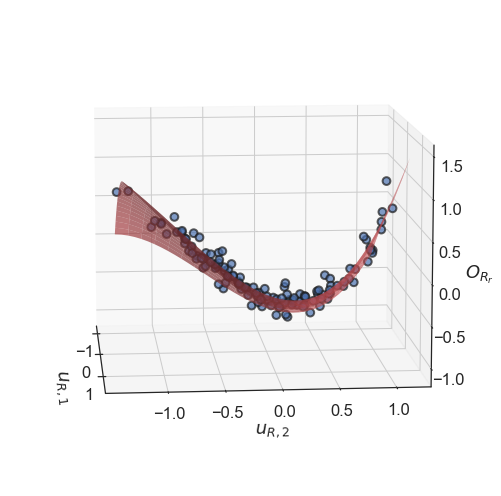

(<Figure size 504x504 with 1 Axes>,
 <Axes3DSubplot:xlabel='$u_{R,1}$', ylabel='$u_{R,2}$'>)

In [64]:
fig = plt.figure(tight_layout=True,figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$u_{R,1}$',labelpad=10); ax.set_xticks([-1,0,1])
ax.set_ylabel('$u_{R,2}$',labelpad=10)
ax.set_zlabel('$O_{R_r}$',labelpad=10,rotation=0)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=10, azim=-5)
mysubspace2.plot_sufficient_summary(ax=ax)